## Observations and Insights

We observe from the final figure that there appears to be a correlation between the weight of a mouse and the average tumor volume after treatment by Capomulin. This suggests that the drug is less effective at reducing Tumor volume the larger a mouse is.

From the Quartile Ranges figure, we observe that Capumulin and Ramicane is more effective than Infubinol and Ceftamin.

We also observe only one outlier for the Infubinol drug regimen. This is most likely accounted for by the observation that tumor volume appears to grow while on Infubinol, and the data includes mice on Infubinol who did not complete the trial (i.e. final time point is less than 45).



## Dependencies and starter code

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import math
from numpy import linalg as LA
import re
import sys

# Study data files
mouse_metadata = "data/Mouse_metadata.csv"
study_results = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata_df = pd.read_csv(mouse_metadata)
study_results_df = pd.read_csv(study_results)

main_df =  pd.merge(study_results_df, mouse_metadata_df, on="Mouse ID")

## Summary statistics

In [2]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
regimen_group_df = main_df.groupby('Drug Regimen')
vol_stat_df = regimen_group_df['Tumor Volume (mm3)'].describe()[['count','mean','std','50%']]

#Manual calculation of SEM
vol_stat_var = vol_stat_df['std']*vol_stat_df['std']
vol_stat_sqrt_count = [math.sqrt(x) for x in vol_stat_df['count']]
vol_stat_sem = vol_stat_df['std']/vol_stat_sqrt_count

#Function calculation of SEM
vol_stat_sem2 = regimen_group_df['Tumor Volume (mm3)'].sem()

#Print norm value of difference of manual and function calculation of SEM
print(f"My calculation versus python calculation of SEM of Tumor Volume "
      f"for all drug regimens is within {LA.norm(vol_stat_sem-vol_stat_sem2)} of each other.")

vol_stat_df['Var'] = vol_stat_var
vol_stat_df['SEM'] = vol_stat_sem

vol_stat_df

My calculation versus python calculation of SEM of Tumor Volume for all drug regimens is within 4.996003610813204e-16 of each other.


,count,mean,std,50%,Var,SEM
Drug Regimen,,,,,,
Capomulin,230.0,40.675741,4.994774,41.557809,24.947764,0.329346
Ceftamin,178.0,52.591172,6.268188,51.776157,39.290177,0.469821
Infubinol,178.0,52.884795,6.567243,51.820584,43.128684,0.492236
Ketapril,188.0,55.235638,8.279709,53.698743,68.553577,0.603860
Naftisol,186.0,54.331565,8.134708,52.509285,66.173479,0.596466
Placebo,181.0,54.033581,7.821003,52.288934,61.168083,0.581331
Propriva,161.0,52.322552,6.507770,50.854632,42.351070,0.512884
Ramicane,228.0,40.216745,4.846308,40.673236,23.486704,0.320955
Stelasyn,181.0,54.233149,7.710419,52.431737,59.450562,0.573111


## Bar plots

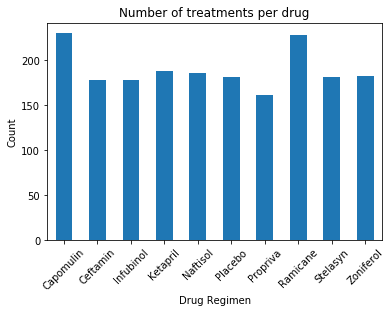

In [3]:
# Generate a bar plot showing number of data points for each treatment regimen using pandas
stat_index_list = list(vol_stat_df.index)
x_axis = [x for x in range(0,len(stat_index_list))]
df_bar_plot = vol_stat_df.plot(None, 'count', kind='bar',title="Number of treatments per drug",legend=False,align="center",
                xticks = x_axis)
df_bar_plot.set_xticklabels(stat_index_list, rotation=45)
df_bar_plot.set_ylabel("Count")
plt.show()

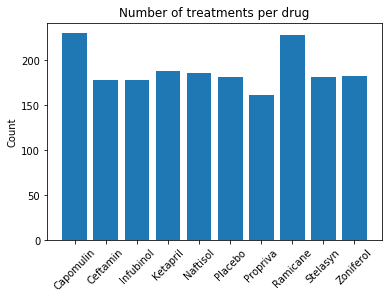

In [4]:
# Generate a bar plot showing number of data points for each treatment regimen using pyplot
plt.bar(x_axis,vol_stat_df['count'],align="center")
plt.xticks(x_axis, stat_index_list, rotation=45)
plt.title("Number of treatments per drug")
plt.ylabel("Count")
plt.show()

## Pie plots

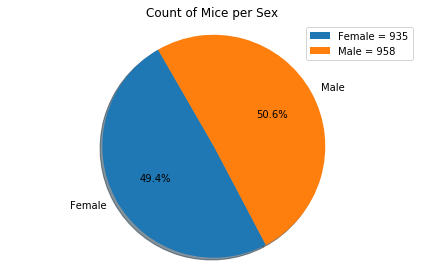

In [5]:
# Generate a pie plot showing the distribution of female versus male mice using pandas
sex_group_df = main_df.groupby('Sex')
df_pie_plot = sex_group_df["Mouse ID"].count().plot(kind = 'pie', title="Count of Mice per Sex",
                                                   autopct="%1.1f%%", shadow=True, startangle=120, legend=True)
df_pie_plot.set_ylabel('')
leg_list = [f"{sex_group_df['Mouse ID'].count().index[0]} = {sex_group_df['Mouse ID'].count()[0]}", 
            f"{sex_group_df['Mouse ID'].count().index[1]} = {sex_group_df['Mouse ID'].count()[1]}"]
df_pie_plot.legend(leg_list)
plt.tight_layout()
plt.axis("Equal")
plt.show()

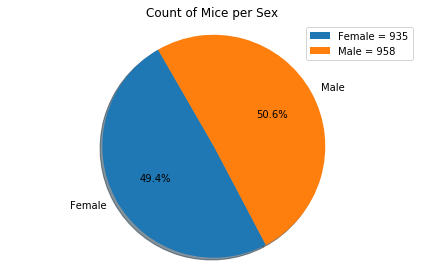

In [6]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
pie_plot = plt.pie(sex_group_df["Mouse ID"].count(), labels = sex_group_df["Mouse ID"].count().index, 
                   autopct="%1.1f%%", shadow=True, startangle=120)
plt.title("Count of Mice per Sex")
plt.legend(leg_list)
plt.tight_layout()
plt.axis("Equal")
plt.show()

## Quartiles, outliers and boxplots

In [13]:
# Calculate the final tumor volume of each mouse across four of the most promising treatment regimens. Calculate the IQR and quantitatively determine if there are any potential outliers.
drug_list = ['Capomulin','Ramicane','Infubinol','Ceftamin']

# Reduce dataFrame by grabbing rows that represent the final timepoint per Drug Regimen, per Mouse ID
regimen_max_time_df = main_df.loc[(main_df.groupby(['Drug Regimen', 'Mouse ID'])['Timepoint'].agg(pd.Series.idxmax)),:]
#print(regimen_max_time_df[['Mouse ID', 'Drug Regimen', 'Timepoint', 'Tumor Volume (mm3)']].to_string())

# Reduce dataFrame to just the specified drugs, then group on the name of the drug
regimen_most_group_df  = regimen_max_time_df.loc[(regimen_max_time_df['Drug Regimen'].isin(drug_list)),:].groupby('Drug Regimen')

quartiles = regimen_most_group_df['Tumor Volume (mm3)'].quantile([.25,.5,.75])
upperq = [quartiles[x] for x in quartiles.keys() if x[1] == 0.75]
lowerq = [quartiles[x] for x in quartiles.keys() if x[1] == 0.25]
iqr = [upperq[x]-lowerq[x] for x in range(0,len(upperq))]
lbound = [lowerq[x] - (1.5*iqr[x]) for x in range(0,len(upperq))]
ubound = [upperq[x] + (1.5*iqr[x]) for x in range(0,len(upperq))]

# Ensure list of drugs coincides with the order in the quartile series
drug_list.sort()

for x in range(0,len(upperq)):
    print(f"The lower quartile of Final Tumor Volume for {drug_list[x]} is {round(lowerq[x],2)} mm^3,"
          f" with an upper quartile of {round(upperq[x],2)} mm^3"
          f" and an iterquartile range of {round(iqr[x],2)} mm^3.\n")

for x in range(0,len(upperq)):
    print(f"Values below {round(lbound[x],2)} mm^3 and above {round(ubound[x],2)} mm^3 are potential outliers for {drug_list[x]}.")
    


     Mouse ID Drug Regimen  Timepoint  Tumor Volume (mm3)
9        b128    Capomulin         45           38.982878
1710     b742    Capomulin         45           38.939633
1882     f966    Capomulin         20           30.485985
1834     g288    Capomulin         45           37.074024
1824     g316    Capomulin         45           40.159220
1867     i557    Capomulin         45           47.685963
1794     i738    Capomulin         45           37.311846
1764     j119    Capomulin         45           38.125164
1680     j246    Capomulin         35           38.753265
1730     l509    Capomulin         45           41.483008
1844     l897    Capomulin         45           38.846876
1892     m601    Capomulin         45           28.430964
1877     m957    Capomulin         45           33.329098
1744     r157    Capomulin         15           46.539206
1690     r554    Capomulin         45           32.377357
1804     r944    Capomulin         45           41.581521
1700     s185 

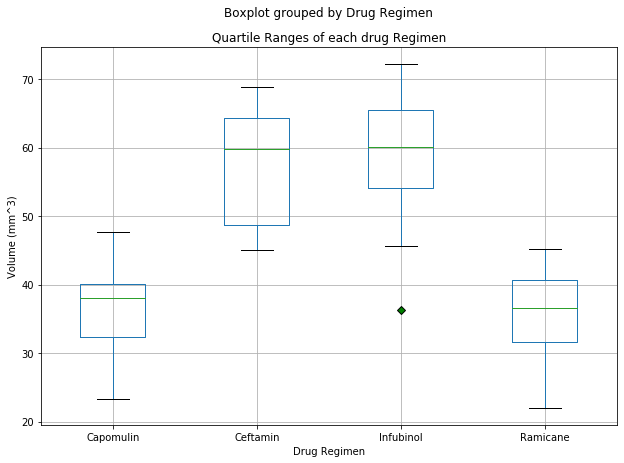

In [12]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest
fig1, ax1 = plt.subplots(figsize = (10,7))
ax1.set_ylabel('Volume (mm^3)')
regimen_most_df = regimen_max_time_df.loc[(regimen_max_time_df['Drug Regimen'].isin(drug_list)),:]

green_diamond = dict(markerfacecolor='g', marker='D')
regimen_most_df.boxplot(column = 'Tumor Volume (mm3)', by = 'Drug Regimen', ax = ax1, flierprops=green_diamond)
ax1.set_title('Quartile Ranges of each drug Regimen')
plt.show()

## Line and scatter plots

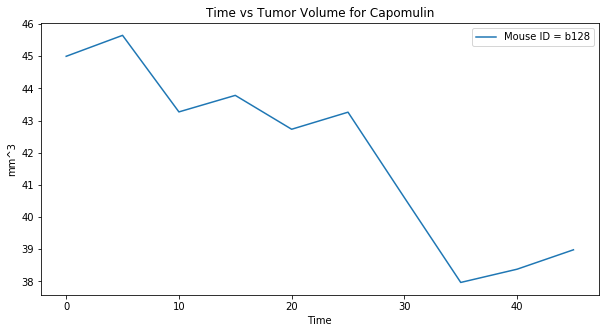

In [9]:
# Generate a line plot of time point versus tumor volume for a mouse treated with Capomulin
mouse_id = main_df.loc[(main_df['Drug Regimen'].isin(['Capomulin'])),'Mouse ID'][0]
data = main_df.loc[(main_df['Drug Regimen'].isin(['Capomulin'])) & (main_df['Mouse ID']==mouse_id),['Timepoint', 'Tumor Volume (mm3)']]
data_plot = data.plot('Timepoint', 'Tumor Volume (mm3)', kind = 'line', title = "Time vs Tumor Volume for Capomulin", legend=True, figsize = (10,5))
data_plot.set_xlabel('Time')
data_plot.set_ylabel('mm^3')
data_plot.legend([f"Mouse ID = {mouse_id}"], loc='best')
plt.show()

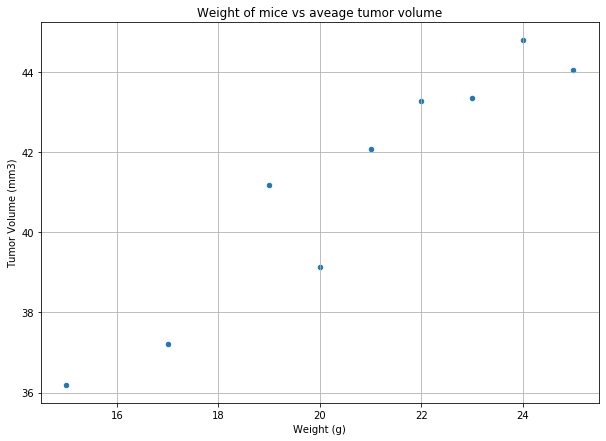

In [10]:
# Generate a scatter plot of mouse weight versus average tumor volume for the Capomulin regimen
mouse_scatter = main_df.loc[main_df['Drug Regimen'] == 'Capomulin', ['Weight (g)','Tumor Volume (mm3)']].groupby('Weight (g)').mean().reset_index()
fig7 = mouse_scatter.plot(kind='scatter', x = 'Weight (g)', y = 'Tumor Volume (mm3)', title = 'Weight of mice vs aveage tumor volume', figsize = (10,7), grid = True)
plt.show()

The r-squared is: 0.90349662774386


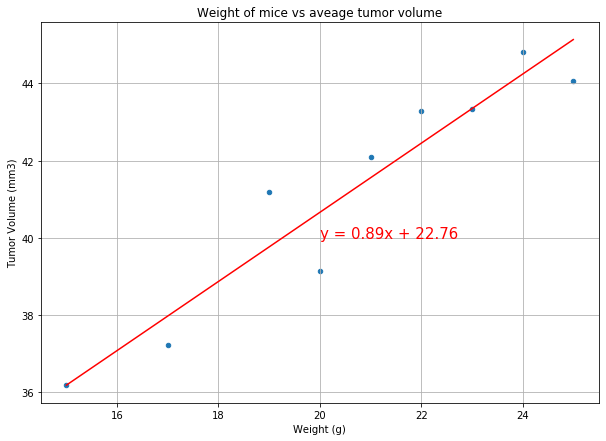

In [11]:
# Calculate the correlation coefficient and linear regression model for mouse weight and average tumor volume for the Capomulin regimen
mouse_scatter = main_df.loc[main_df['Drug Regimen'] == 'Capomulin', ['Weight (g)','Tumor Volume (mm3)']].groupby('Weight (g)').mean().reset_index()
fig7 = mouse_scatter.plot(kind='scatter', x = 'Weight (g)', y = 'Tumor Volume (mm3)', title = 'Weight of mice vs aveage tumor volume', figsize = (10,7), grid = True)

x_values = mouse_scatter['Weight (g)']
y_values = mouse_scatter['Tumor Volume (mm3)']
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(20,40),fontsize=15,color="red")
print(f"The r-squared is: {rvalue**2}")
plt.show()